# X-Ray

Imports


In [66]:
import os
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt

### Data check

In [67]:

# Path to the dataset
dataset_path = 'data/raw/covid-chest-xray'

# Dictionary to store image counts per folder
folder_image_counts = {}

# Iterate through each subdirectory
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # List all files in the folder
        all_files = os.listdir(folder_path)
        
        # Filter image files (assuming they have common image extensions)
        image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Count the number of images in the folder
        folder_image_counts[folder] = len(image_files)

# Print the image counts per folder
for folder, count in folder_image_counts.items():
    print(f"{folder}: {count} images")


Bacterial: 48 images
COVID-19: 342 images
Normal: 486 images


Ignoramos bacterial o hacemos data-augmentation para balancear las clases?


Generamos carpeta con las imagenes de train y test


In [68]:
# # Path to the original dataset and output directory
# dataset_path = "data/raw/covid-chest-xray"
# output_path = "data/split/covid-chest-xray"

# # Define train-test split ratio
# train_ratio = 0.8

# # Create train and test directories
# train_path = os.path.join(output_path, "train")
# test_path = os.path.join(output_path, "test")

# # Ensure directories exist
# os.makedirs(train_path, exist_ok=True)
# os.makedirs(test_path, exist_ok=True)

# # Iterate through each category (subfolder)
# for category in os.listdir(dataset_path):
#     category_path = os.path.join(dataset_path, category)
    
#     # Check if it's a directory
#     if os.path.isdir(category_path):
#         # Create corresponding train/test subfolders
#         train_category_path = os.path.join(train_path, category)
#         test_category_path = os.path.join(test_path, category)
#         os.makedirs(train_category_path, exist_ok=True)
#         os.makedirs(test_category_path, exist_ok=True)
        
#         # Get all image files
#         all_images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#         random.shuffle(all_images)  # Shuffle to randomize selection

#         # Split data
#         train_count = int(len(all_images) * train_ratio)
#         train_images = all_images[:train_count]
#         test_images = all_images[train_count:]

#         # Move images to respective folders
#         for img in train_images:
#             shutil.copy2(os.path.join(category_path, img), os.path.join(train_category_path, img))
        
#         for img in test_images:
#             shutil.copy2(os.path.join(category_path, img), os.path.join(test_category_path, img))

#         print(f"Processed {category}: {len(train_images)} train, {len(test_images)} test")



In [69]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [70]:
train_generator = train_datagen.flow_from_directory(
    'data/split/covid-chest-xray/train',
    target_size=(150, 150),
    batch_size=25,
    class_mode='binary') #class_mode='categorical' cambiar si metemos bacterial

Found 661 images belonging to 2 classes.


In [71]:
validation_generator = test_datagen.flow_from_directory(
    'data/split/covid-chest-xray/test',
    target_size=(150, 150),
    batch_size=25,
    class_mode='binary') #class_mode='categorical' cambiar si metemos bacterial

Found 167 images belonging to 2 classes.


In [72]:
# Load the VGG16 model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True


In [73]:
for layer in conv_base.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
    else:
        layer.trainable = False

In [74]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [75]:
# Create a new model and add the VGG16 base
model = models.Sequential()
model.add(conv_base)

# Add new layers on top of the VGG16 base
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=50, #100
    epochs=15, #30
    validation_data=validation_generator,
    validation_steps=50)

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
27/50 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6932 - loss: 0.6569

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7467 - loss: 0.5564 - val_accuracy: 0.9880 - val_loss: 0.0402
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9478 - loss: 0.1499 - val_accuracy: 0.9820 - val_loss: 0.0311
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9571 - loss: 0.1156 - val_accuracy: 0.9760 - val_loss: 0.0586
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9670 - loss: 0.0956 - val_accuracy: 0.9940 - val_loss: 0.0242
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9829 - loss: 0.0541 - val_accuracy: 0.9820 - val_loss: 0.0233
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9719 - loss: 0.0747 - val_accuracy: 0.9940 - val_loss: 0.0302
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9723 - loss: 0.0745 - val_accuracy: 0.9880 - val_loss: 0.0185
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9864 - loss: 0.0518 - val_accuracy: 0.9820 - val_loss: 0.0401
Epo

In [76]:
history_dict = history.history

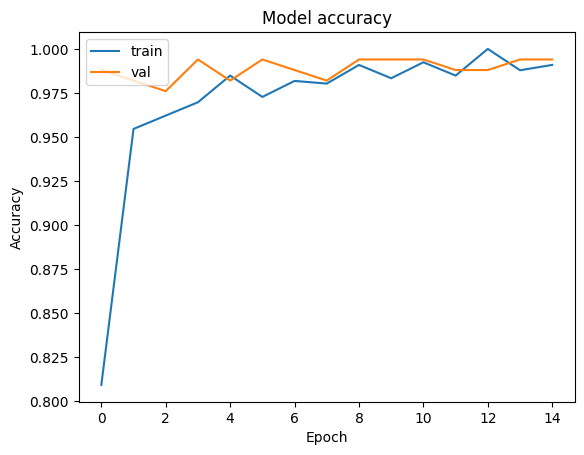

In [77]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

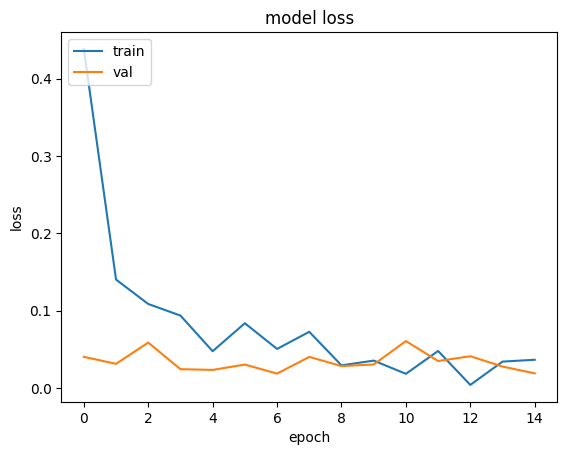

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()